In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import numpy as np
import pandas as pd
from zipfile import ZipFile
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tensorflow.keras.utils import plot_model

In [2]:
zip_file = ZipFile('basketball_data.zip')
games_season_enriched, games_season, games_tourney = \
[pd.read_csv(zip_file.open(text_file.filename))
 for text_file in zip_file.infolist()
 if text_file.filename.endswith('.csv')]

games_season_enriched.shape, games_season.shape, games_tourney.shape

((4234, 10), (312178, 8), (4234, 9))

# Three-input models

## Simple model with 3 inputs

In [3]:
from tensorflow.keras.layers import Input, Concatenate, Dense
in_tensor_1 = Input(shape=(1,))
in_tensor_2 = Input(shape=(1,))
in_tensor_3 = Input(shape=(1,))
out_tensor = Concatenate()([in_tensor_1, in_tensor_2, in_tensor_3])
output_tensor = Dense(1)(out_tensor)

2023-02-14 14:06:38.644325: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 3)            0           ['input_1[0][0]',                
                                                                  'input_2[0][0]',            

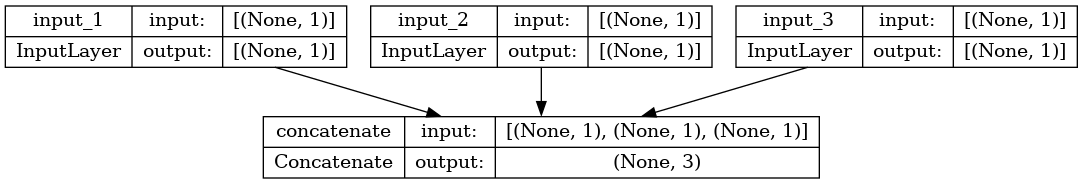

In [4]:
from tensorflow.keras.models import Model
model = Model([in_tensor_1, in_tensor_2, in_tensor_3], out_tensor)
model.summary()
plot_model(model, expand_nested=True, show_shapes=True)

## Shared layers with 3 inputs

In [5]:
shared_layer = Dense(1)
shared_tensor_1 = shared_layer(in_tensor_1)
shared_tensor_2 = shared_layer(in_tensor_2)
out_tensor = Concatenate()([shared_tensor_1, shared_tensor_2, in_tensor_3])
out_tensor = Dense(1)(out_tensor)

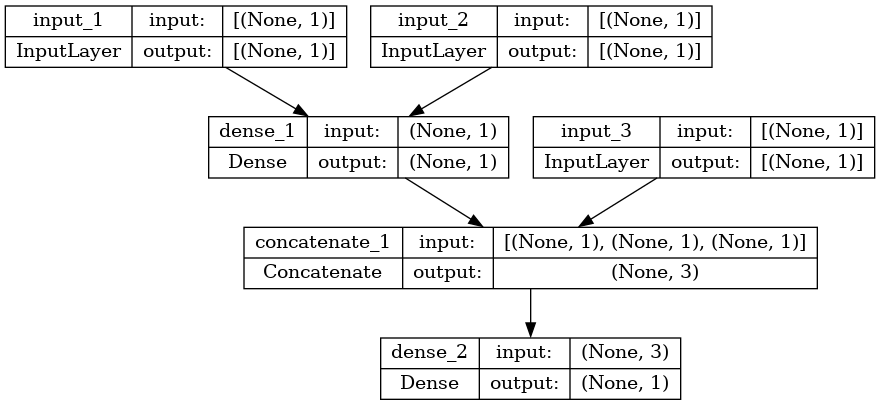

In [6]:
from tensorflow.keras.models import Model
model = Model([in_tensor_1, in_tensor_2, in_tensor_3], out_tensor)
plot_model(model, expand_nested=True, show_shapes=True)

## Fitting a 3 input model

    from tensorflow.keras.models import Model
    model = Model([in_tensor_1, in_tensor_2, in_tensor_3], out_tensor)
    model.compile(loss='mae', optimizer='adam')
    model.fit([train['col1'], train['col2'], train['col3']],
               train_data['target'])
    model.evaluate([test['col1'], test['col2'], test['col3']],
                    test['target'])

## Exercises

### Make an input layer for home vs. away

Now you will make an improvement to the model you used in the previous chapter for regular season games. You know there is a well-documented home-team advantage in basketball, so you will add a new input to your model to capture this effect.

This model will have three inputs: team_id_1, team_id_2, and home. The team IDs will be integers that you look up in your team strength model from the previous chapter, and home will be a binary variable, 1 if team_1 is playing at home, 0 if they are not.

The team_strength_model you used in the previous chapter has been loaded into your workspace.

In [7]:
from tensorflow.keras.layers import Embedding, Flatten
n_teams = games_season['team_1'].unique().shape[0]
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

teamid_in = Input(shape=(1,))
strength_lookup = team_lookup(teamid_in)
strength_lookup_flat = Flatten()(strength_lookup)
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

After applying it to each input, use a Concatenate layer to join the two team strengths and with the home vs away variable, and pass the result to a Dense layer.

In [8]:
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

### Make a model and compile it

Now that you've input and output layers for the 3-input model, wrap them up in a Keras model class, and then compile the model, so you can fit it to data and use it to make predictions on new data.

In [9]:
# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

### Fit the model and evaluate

Now that you've defined a new model, fit it to the regular season basketball data.

Use the model you fit in the previous exercise (which was trained on the regular season data) and evaluate the model on data for tournament games (games_tourney).

In [10]:
# Fit the model to the games_season dataset
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1,
          verbose=True,
          validation_split=0.1,
          batch_size=2048)

# Evaluate the model on the games_tourney dataset
print(model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']], games_tourney['score_diff'], verbose=False))

138/138 [==============================] - 0s 1ms/step - loss: 12.1027 - val_loss: 12.0606
11.68377685546875


# Summarizing and plotting models

In [11]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Team-1-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Team-2-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Team-Strength-Model (Functiona  (None, 1)           10888       ['Team-1-In[0][0]',              
 l)                                                               'Team-2-In[0][0]']              
                                                                                                  
 Home-In (InputLayer)           [(None, 1)]          0           []                         

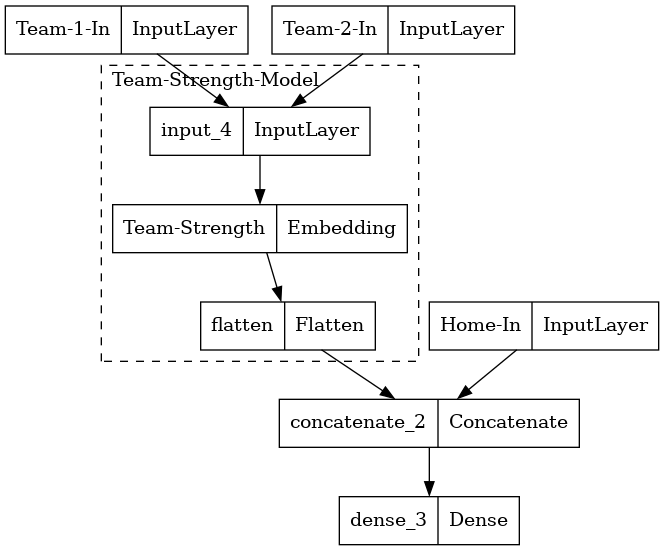

In [12]:
plot_model(model, expand_nested=True)

# Stacking models

## Stacking models requires 2 datasets

In [13]:
games_season_enriched

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won,pred
0,1985,288,73,0,-3,-9,41,50,0,-3.601452
1,1985,5929,73,0,4,6,61,55,1,0.474164
2,1985,9884,73,0,5,-4,59,63,0,-0.414316
3,1985,73,288,0,3,9,50,41,1,3.601452
4,1985,3920,410,0,1,-9,54,63,0,8.176179
...,...,...,...,...,...,...,...,...,...,...
4229,2017,10120,10696,0,-1,-10,74,84,0,-5.840316
4230,2017,320,10818,0,9,-2,71,73,0,3.959683
4231,2017,2910,10818,0,8,-25,66,91,0,6.244301
4232,2017,3300,10818,0,10,24,83,59,1,11.307431


In [14]:
games_season

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1
...,...,...,...,...,...,...,...,...
312173,2018,3592,1481,1,-1,55,56,0
312174,2018,7322,2081,1,-1,57,58,0
312175,2018,9730,3233,1,-13,61,74,0
312176,2018,8813,4297,1,-5,72,77,0


In [15]:
games_tourney

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0
...,...,...,...,...,...,...,...,...,...
4229,2017,10120,10696,0,-1,-10,74,84,0
4230,2017,320,10818,0,9,-2,71,73,0
4231,2017,2910,10818,0,8,-25,66,91,0
4232,2017,3300,10818,0,10,24,83,59,1


## Enrich the tournament data

Recall that our embedding layer has about 11,000 inputs. 4,000 rows of data is not enough to learn all 11,000 parameters in our embedding layer. In the previous lesson, you built a three-input model on the regular season data. You can re-use this model to add predictions from the regular season model to the tournament dataset. 

You start with the regular season dataset and fit a model to it. You then predict on the tournament dataset, using this model. This gives you predicted tournament outcomes, which you can now use to build a better model of the actual tournament outcomes. You additionally use the tournament seeds when modeling the tournament. These tournament seeds come from a committee, and are intended to, like your model, capture each team's "strength," without using an embedding layer. The tournament seeds can be thought of as a simplified version of your team strength model, determined by a human rather than a computer. 

In [16]:
in_data_1 = games_tourney['team_1']
in_data_2 = games_tourney['team_2']
in_data_3 = games_tourney['home']
pred = model.predict([in_data_1, in_data_2, in_data_3])
games_tourney['pred'] = pred
games_tourney.head()

133/133 [==============================] - 0s 289us/step


,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won,pred
0,1985,288,73,0,-3,-9,41,50,0,0.094227
1,1985,5929,73,0,4,6,61,55,1,0.104661
2,1985,9884,73,0,5,-4,59,63,0,0.083564
3,1985,73,288,0,3,9,50,41,1,0.111055
4,1985,3920,410,0,1,-9,54,63,0,0.174674


## 3 input model with pure numeric data

The prediction from the regular season model captures the effects of team_1 and team_2, which means you now don't need to use those two variables in the tournament model, and can avoid the use of an embedding layer. You can focus your modeling efforts on the purely numeric data, which is a little easier to work with. With purely numeric inputs, you can pass all of them to a single input layer.

In other words, an input layer with a shape of 3 is another way of defining a 3 input model. The only drawback of this approach is that all the inputs must be numeric.

A huge advantage of this approach is simplicity. You can create a model with a single input tensor and an output tensor, and fit it using a single dataset. Similarly, evaluating the model requires a single dataset, rather than a list. As you can see, this stacked model is pretty accurate! It's off, on average, by about 9 points in a given game. 

In [17]:
games_tourney[['home','seed_diff','pred']].head()

,home,seed_diff,pred
0,0,-3,0.094227
1,0,4,0.104661
2,0,5,0.083564
3,0,3,0.111055
4,0,1,0.174674


    in_tensor = Input(shape=(3,))
    out_tensor = Dense(1)(in_tensor)

    model = Model(in_tensor, out_tensor)
    model.compile(optimizer='adam', loss='mae')

    train_X = train_data[['home','seed_diff','pred']]
    train_y = train_data['score_diff']
    model.fit(train_X,train_y, epochs=10, validation_split=.10)

    test_X = test_data[['home','seed_diff','pred']]
    test_y = test_data['score_diff']
    model.evaluate(test_X, test_y)

To recap: stacking keras models means using the predictions from one model as an input to a second model. When stacking, it's important to use different datasets for each model. In this case, you use the regular season data for one model and the tournament dataset for the second model. Finally, if your input dataset is purely numeric, you can put multiple inputs in a single input layer. Lets practice using these concepts! 

## Exercises

### Add the model predictions to the tournament data

In lesson 1 of this chapter, you used the regular season model to make predictions on the tournament dataset, and got pretty good results! Try to improve your predictions for the tournament by modeling it specifically.

You'll use the prediction from the regular season model as an input to the tournament model. This is a form of "model stacking."

To start, take the regular season model from the previous lesson, and predict on the tournament data. Add this prediction to the tournament data as a new column.

In [ ]:
# Predict
games_tourney['pred'] = model.predict([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']])

133/133 [==============================] - 0s 322us/step


Now you can try building a model for the tournament data based on your regular season predictions.

### Create an input layer with multiple columns

In this exercise, you will look at a different way to create models with multiple inputs. This method only works for purely numeric data, but its a much simpler approach to making multi-variate neural networks.

Now you have three numeric columns in the tournament dataset: 'seed_diff', 'home', and 'pred'. In this exercise, you will create a neural network that uses a single input layer to process all three of these numeric inputs.

This model should have a single output to predict the tournament game score difference.

In [21]:
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

Now your model is ready to meet some data!

### Fit the model

Now that you've enriched the tournament dataset and built a model to make use of the new data, fit that model to the tournament data.

Note that this model has only one input layer that is capable of handling all 3 inputs, so it's inputs and outputs do not need to be a list.

Tournament games are split into a training set and a test set. The tournament games before 2010 are in the training set, and the ones after 2010 are in the test set.

In [28]:
games_tourney_train = games_tourney[games_tourney['season']<2010]
games_tourney_test = games_tourney[ games_tourney['season']>=2010]

In [30]:
# Fit the model
model.fit(games_tourney_train[['home', 'seed_diff', 'pred']],
          games_tourney_train['score_diff'],
          epochs=1,
          verbose=True)

99/99 [==============================] - 0s 325us/step - loss: 9.2064


In the next exercise, you'll see if our model is any good!

### Evaluate the model

Now that you've fit your model to the tournament training data, evaluate it on the tournament test data. Recall that the tournament test data contains games from after 2010.

In [32]:
# Evaluate the model on the games_tourney_test dataset
print(model.evaluate(games_tourney_test[['home', 'seed_diff', 'pred']],
                     games_tourney_test['score_diff'], verbose=False))

9.075745582580566
